# Load the Data

In [120]:
!ls data

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
AviationData.csv  USState_Codes.csv


In [121]:
#load the CSV files for the rest of the project

#pandas says columns 6, 7, and 28 have mixed data types.  
#For now we will set them to strings to avoid errors later
'''
Latitude and Longitude have two formats in the file.  One is degrees, minutes, seconds format 
with a suffix for hemisphere like N
The other format is called decimal degrees and it is a float.
'''

#latin1 is required as utf-8 will not load
#load 5 rows just for column names, a full load shows mixed data type warnings on columns 6, 7, 28
#so we will tell pandas to load them as strings
aviation_data = pd.read_csv("data/AviationData.csv",encoding="latin1", nrows=1)
col_list = list(aviation_data.columns)
dtype_spec = {
    col_list[6]: 'str', #Latitude
    col_list[7]: 'str', #Longitude
    col_list[28]: 'str' #Broad.phase.of.flight
}

#now load it in full without warnings
aviation_data = pd.read_csv("data/AviationData.csv",encoding="latin1", dtype=dtype_spec)
uscode_data = pd.read_csv("data/USState_Codes.csv")

# Standardize Column Names

In [122]:
aviation_data.columns = aviation_data.columns.str.lower().str.replace(' ', '_',regex=False).str.replace('.','_',regex=False)

# Info() and null count

In [123]:
#initial missing data check before cleaning/standardization
null_counts_before_standardization = aviation_data.isnull().sum()
aviation_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   event_id                88889 non-null  object 
 1   investigation_type      88889 non-null  object 
 2   accident_number         88889 non-null  object 
 3   event_date              88889 non-null  object 
 4   location                88837 non-null  object 
 5   country                 88663 non-null  object 
 6   latitude                34382 non-null  object 
 7   longitude               34373 non-null  object 
 8   airport_code            50132 non-null  object 
 9   airport_name            52704 non-null  object 
 10  injury_severity         87889 non-null  object 
 11  aircraft_damage         85695 non-null  object 
 12  aircraft_category       32287 non-null  object 
 13  registration_number     87507 non-null  object 
 14  make                    88826 non-null

# Mixed Data Type Issue with Longitude, Latitude

For latitude and longitude they mix formats.  Some are in degrees, minutes and seconds format with a suffix like 'N' for direction.  Some are in decimal degrees, which are easier to work with mathematically.

In [124]:
#To know to pass str types for columns 6, 7 and 28 we had to know what is up with those columns
#We do value_counts to see if one issue comes up a lot and inspect some initial values
aviation_data['latitude'].value_counts()

latitude
332739N      19
335219N      18
334118N      17
32.815556    17
324934N      16
             ..
039613N       1
342034N       1
433113N       1
343255N       1
373829N       1
Name: count, Length: 25589, dtype: int64

In [125]:
aviation_data['longitude'].value_counts()

longitude
0112457W       24
1114342W       18
1151140W       17
-104.673056    17
-112.0825      16
               ..
0843135W        1
0101957W        1
1064131W        1
1114414W        1
0121410W        1
Name: count, Length: 27154, dtype: int64

## mixed data type for broad_phase_of_flight 
This is likely due to NaN, but needs more investigation

In [126]:
aviation_data['broad_phase_of_flight'].head()

0      Cruise
1     Unknown
2      Cruise
3      Cruise
4    Approach
Name: broad_phase_of_flight, dtype: object

In [127]:
aviation_data['broad_phase_of_flight'].value_counts()

broad_phase_of_flight
Landing        15428
Takeoff        12493
Cruise         10269
Maneuvering     8144
Approach        6546
Climb           2034
Taxi            1958
Descent         1887
Go-around       1353
Standing         945
Unknown          548
Other            119
Name: count, dtype: int64

In [128]:
aviation_data['broad_phase_of_flight'].isna().sum()

27165

In [129]:
aviation_data[aviation_data['broad_phase_of_flight'].isna()]['broad_phase_of_flight'].head()

3030    NaN
3550    NaN
3637    NaN
4032    NaN
5505    NaN
Name: broad_phase_of_flight, dtype: object

# Standardize Data

Lets attack getting rid of duplicate labels.  We checked ahead and there's a lot of labels duplicated for a lot of reasons.  This attempts to get rid of all of that.

In [130]:
#lowercase and stripe white space, this removes a lot of duplicate labels
def standardize_string(s):
    if pd.isna(s):
        return s
    if isinstance(s,str):
        s = s.strip().lower()#.replace(' ','_')
    return s

#for some columns treating none as nan helps us do analysis
def none_to_None(s):
    if s == 'none':
        return None #None is the NaN for object columns
    return s

def unknown_to_None(s):
    if s == 'unknown':
        return None
    return s

#for some columns unk is short for unknown but unknown will still be listed, so standardize it
def unk_to_unknown(s):
    if s == 'unk':
        return 'unknown'
    return s

def replace_in_cols(cols,map):
    aviation_data[cols] = aviation_data[cols].applymap(map)


#display(aviation_data.head())
#we are excluding latitude and longitude bc capital N instead of lowercase n is how it is supposed to be
exclude_cols = ['latitude','longitude']
#an array of True and False that will have False for the columns we put in exclude_cols
include_mask = ~aviation_data.columns.isin(exclude_cols)
#loc is used here to target the dataframe columns with the include mask.
#say latitude is the 4th column, the array would have False for the 4th column and that would
#mean pandas doesn't select the 4th column.
#this is just easier than listing all the columns but 2
aviation_data.loc[:,include_mask] = aviation_data.loc[:,include_mask].applymap(standardize_string)

replace_in_cols(['airport_code','airport_name','registration_number'], none_to_None)
replace_in_cols(['aircraft_category','registration_number','engine_type','far_description'], unk_to_unknown)
replace_in_cols(['engine_type','aircraft_damage','registration_number'], unknown_to_None)

#make date strings into datetimes
aviation_data['publication_date'] = pd.to_datetime(aviation_data['publication_date'],format='%d-%m-%Y')

aviation_data.head()

/var/folders/1k/x4fbmx7x5jq2rlv4qntp985r0000gn/T/ipykernel_29212/1225123856.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  aviation_data.loc[:,include_mask] = aviation_data.loc[:,include_mask].applymap(standardize_string)
/var/folders/1k/x4fbmx7x5jq2rlv4qntp985r0000gn/T/ipykernel_29212/1225123856.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  aviation_data[cols] = aviation_data[cols].applymap(map)
/var/folders/1k/x4fbmx7x5jq2rlv4qntp985r0000gn/T/ipykernel_29212/1225123856.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  aviation_data[cols] = aviation_data[cols].applymap(map)
/var/folders/1k/x4fbmx7x5jq2rlv4qntp985r0000gn/T/ipykernel_29212/1225123856.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  aviation_data[cols] = aviation_data[cols].applymap(map)


,event_id,investigation_type,accident_number,event_date,location,country,latitude,longitude,airport_code,airport_name,...,purpose_of_flight,air_carrier,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,weather_condition,broad_phase_of_flight,report_status,publication_date
0,20001218x45444,accident,sea87la080,1948-10-24,"moose creek, id",united states,NaN,NaN,NaN,NaN,...,personal,NaN,2.0,0.0,0.0,0.0,unk,cruise,probable cause,NaT
1,20001218x45447,accident,lax94la336,1962-07-19,"bridgeport, ca",united states,NaN,NaN,NaN,NaN,...,personal,NaN,4.0,0.0,0.0,0.0,unk,unknown,probable cause,1996-09-19
2,20061025x01555,accident,nyc07la005,1974-08-30,"saltville, va",united states,36.922223,-81.878056,NaN,NaN,...,personal,NaN,3.0,NaN,NaN,NaN,imc,cruise,probable cause,2007-02-26
3,20001218x45448,accident,lax96la321,1977-06-19,"eureka, ca",united states,NaN,NaN,NaN,NaN,...,personal,NaN,2.0,0.0,0.0,0.0,imc,cruise,probable cause,2000-09-12
4,20041105x01764,accident,chi79fa064,1979-08-02,"canton, oh",united states,NaN,NaN,NaN,NaN,...,personal,NaN,1.0,2.0,NaN,0.0,vmc,approach,probable cause,1980-04-16


## Split injury_severity

In [131]:
#split the fatal(123) format into two diff columns
severity = []
number = []
for row in aviation_data['injury_severity']:
    if isinstance(row,str):
        match = re.match(r"(\w+)\((\d+)\)", row)
        if match:
            severity.append(match.group(1))
            number.append(int(match.group(2)))
        else:
            severity.append(row)
            number.append(pd.NA)
    else:
        severity.append(None)
        number.append(pd.NA)

aviation_data['injury_severity_type'] = severity
aviation_data['injury_severity_count'] = number

#converts to int col 
aviation_data['injury_severity_count'] = aviation_data['injury_severity_count'].astype('Int64')

#aviation_data.head()
display(aviation_data[['injury_severity_type','injury_severity_count']])
display(aviation_data['injury_severity_count'])

,injury_severity_type,injury_severity_count
0,fatal,2
1,fatal,4
2,fatal,3
3,fatal,2
4,fatal,1
...,...,...
88884,minor,<NA>
88885,None,<NA>
88886,non-fatal,<NA>
88887,None,<NA>


0           2
1           4
2           3
3           2
4           1
         ... 
88884    <NA>
88885    <NA>
88886    <NA>
88887    <NA>
88888    <NA>
Name: injury_severity_count, Length: 88889, dtype: Int64

## State codes

In [132]:
state_codes = tuple(uscode_data['Abbreviation'].values)
display(uscode_data)
def extract_state(location):
    if pd.notnull(location) and ', ' in location:
        code = location.split(', ')[1].strip().upper()
        if code in state_codes:
            return code
    return None

#split the states into its own column but only if it's 'united states'
#np.where(condition, value if condition is true, value if condition is false)
aviation_data['state'] = np.where(
    aviation_data['country'] == 'united states',
    aviation_data['location'].apply(extract_state),
    None
)

aviation_data['state'].value_counts()

,US_State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
...,...,...
57,Virgin Islands,VI
58,Washington_DC,DC
59,Gulf of mexico,GM
60,Atlantic ocean,AO


state
CA    8857
TX    5913
FL    5825
AK    5672
AZ    2834
CO    2726
WA    2612
IL    2060
MI    2030
GA    2023
NY    1914
OH    1823
PA    1790
OR    1772
NC    1661
MO    1565
WI    1560
AR    1519
MN    1456
ID    1436
NM    1358
UT    1336
IN    1320
VA    1275
OK    1240
NV    1236
LA    1216
NJ    1170
AL    1153
TN    1108
KS    1104
MT    1050
SC     974
MA     969
IA     819
MD     815
MS     813
WY     739
NE     725
KY     650
ND     561
ME     505
CT     502
HI     481
SD     446
WV     394
NH     368
VT     241
RI     158
DE     114
PR     114
GM      44
DC      42
AO      17
PO      14
GU       8
VI       6
Name: count, dtype: int64

## Aviation code check

In [133]:
aviation_data['airport_code'].value_counts()

airport_code
pvt     497
apa     160
ord     149
mri     137
den     115
       ... 
78oh      1
0v6       1
8c3       1
56m       1
eikh      1
Name: count, Length: 10345, dtype: int64

## Fix private variations in airport names

In [134]:
replacements = {
    'private airstrip': 'private',
    'private strip': 'private'
}
aviation_data['airport_name'] = aviation_data['airport_name'].replace(replacements)
aviation_data['airport_name'].value_counts()

airport_name
private                           898
merrill field                     109
centennial                        102
van nuys                           97
north las vegas                    82
                                 ... 
lambert-st. louis int'l             1
williamson mingo cty                1
sanona creek airstrip               1
penns cave                          1
wichita dwight d eisenhower nt      1
Name: count, Length: 21563, dtype: int64

## Compare nulls sum after standardization

In [135]:
null_counts_after_standardization = aviation_data.isnull().sum()
comparison = pd.DataFrame({
    'Before Standardization': null_counts_before_standardization,
    'After Standardization': null_counts_after_standardization
})
#replace_in_cols(['airport_code','airport_name','registration_number'], none_to_nan)
#replace_in_cols(['aircraft_category','registration_number','engine_type','far_description'], unk_to_unknown)
#replace_in_cols(['engine_type','aircraft_damage','registration_number'], unknown_to_nan)
comparison_filtered = comparison[comparison['Before Standardization'] != comparison['After Standardization']]
comparison_filtered

,Before Standardization,After Standardization
aircraft_damage,3194.0,3313
airport_code,38757.0,40252
airport_name,36185.0,36331
engine_type,7096.0,9148
injury_severity_count,NaN,76325
injury_severity_type,NaN,1000
registration_number,1382.0,1752
state,NaN,6756


It looks like we're getting more nulls which is what we wanted in some cases!

In [136]:
aviation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   event_id                88889 non-null  object        
 1   investigation_type      88889 non-null  object        
 2   accident_number         88889 non-null  object        
 3   event_date              88889 non-null  object        
 4   location                88837 non-null  object        
 5   country                 88663 non-null  object        
 6   latitude                34382 non-null  object        
 7   longitude               34373 non-null  object        
 8   airport_code            48637 non-null  object        
 9   airport_name            52558 non-null  object        
 10  injury_severity         87889 non-null  object        
 11  aircraft_damage         85576 non-null  object        
 12  aircraft_category       32287 non-null  object

## Far Description

The 'far_description' has a considerably smaller portion of missing data, compared to columns such as 'purpose_of_flight'. Let's investigate these unique values, to see if we can use them to fill other parts of our missing data. 

We'll organize the values as we go, to make them easier to group. 

In [137]:
aviation_data['far_description'].unique()

array([nan, 'part 129: foreign', 'part 91: general aviation',
       'part 135: air taxi & commuter', 'part 125: 20+ pax,6000+ lbs',
       'part 121: air carrier', 'part 137: agricultural',
       'part 133: rotorcraft ext. load', 'unknown',
       'part 91f: special flt ops.', 'non-u.s., non-commercial',
       'public aircraft', 'non-u.s., commercial', 'public use',
       'armed forces', 'part 91 subpart k: fractional', '091', 'nusc',
       '135', 'nusn', '121', '137', '129', '133', '091k', 'pubu', 'armf',
       '103', '125', '437', '107'], dtype=object)

**129** and **part 129: foreign**: Foreign air carriers or operators who would like to conduct passenger or cargo operations to, from, and transiting the US. A foreign air carrier is a person, not a citizen of the U.S., undertaking by any means to provide foreign air transportation. 

**121** and **part 121: air carrier**: Generally large, U.S.-based airlines, regional air carriers, and all cargo operarters.

**non-u.s., commercial**: non-u.s., commercial

**091** and **part 91: general aviation**: General aviation pilots, operating private aircraft. Non-commercial situations only.

**091k** and **part 91 subpart k: fractional**: For private, not-for-hire use by individuals and companies

**135** and **part 135: air taxi & commuter**: For commuter and on-demand operations (flying passengers on-demand, rather than on a scheduled-basis). Can vary from small single aircraft operators, to large operators providing a network to move cargo to larger carriers. Often offer critical services to remote areas.

**125** and **part 125: 20+ pax,6000+ lbs**: Large group charter flight (non-commercial)

**133** and **part 133: rotorcraft ext. load**: On demand, external load air service, where air carriers utilize helicopters

**137** and **part 137: agricultural**: Dispensing any economic poison, other substance or activities dispensed for agriculture, horticulture, or forest preservation.

**public aircraft**: For governmental use only. 

**public use**: "Public" aircrafts are aircrafts used only by the government, however this label could also be referring to a "public use" airport, which would be for commercial purposes. 

**armed forces**: armed forces

**unknown**: unknown

**part 91f: special flt ops.**: Non-commercial flights only.

**non-u.s., non-commercial'**: non-u.s., non-commercial

**nusc**: nusc

**nusn**: nusn

**pubu**: pubu

**armf**: armf

**103**: Ultraleight vehicles. Purely recreational flights.

**437**: Experimental permit using a suborbital rocket

**107**: Small unmanned aircraft systems

In [138]:
#Lets standardize FAR
# Define the function to standardize the far_description
def standardize_description(description):
    if pd.isna(description):
        return description
    if isinstance(description,str):
        description = description.lstrip('0').strip()
        #description = description.replace('subpart k','k').strip()
    if 'part' in description:
        match = re.search(r'part (\d+):', description)
        if match:
            return match.group(1).strip()
    
    return description

# Apply the function row-wise
aviation_data['far_description'] = aviation_data['far_description'].apply(standardize_description)

display(aviation_data['far_description'].value_counts())
display(aviation_data['far_description'].isna().sum())

far_description
91                               24707
nusn                              1584
137                               1447
135                               1044
nusc                              1013
121                                844
unknown                            393
129                                346
pubu                               253
133                                139
non-u.s., non-commercial            97
non-u.s., commercial                93
public use                          19
91k                                 14
125                                 10
armf                                 8
107                                  4
public aircraft                      2
103                                  2
armed forces                         1
part 91 subpart k: fractional        1
part 91f: special flt ops.           1
437                                  1
Name: count, dtype: int64

56866

# Checking for Missing Data
First we will run some checks on the aviation_data to see what we're dealing with for missing data

In [139]:
aviation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   event_id                88889 non-null  object        
 1   investigation_type      88889 non-null  object        
 2   accident_number         88889 non-null  object        
 3   event_date              88889 non-null  object        
 4   location                88837 non-null  object        
 5   country                 88663 non-null  object        
 6   latitude                34382 non-null  object        
 7   longitude               34373 non-null  object        
 8   airport_code            48637 non-null  object        
 9   airport_name            52558 non-null  object        
 10  injury_severity         87889 non-null  object        
 11  aircraft_damage         85576 non-null  object        
 12  aircraft_category       32287 non-null  object

It seems we are missing a lot of data!  We will need to formulate plans on all of this.
This next code block will let us see how much data is missing percent wise

## Missing Percent

In [140]:
# Calculate the percentage of missing values for each column
missing_perc = aviation_data.isna().mean() * 100
missing_perc

event_id                   0.000000
investigation_type         0.000000
accident_number            0.000000
event_date                 0.000000
location                   0.058500
country                    0.254250
latitude                  61.320298
longitude                 61.330423
airport_code              45.283443
airport_name              40.872324
injury_severity            1.124999
aircraft_damage            3.727120
aircraft_category         63.677170
registration_number        1.970998
make                       0.070875
model                      0.103500
amateur_built              0.114750
number_of_engines          6.844491
engine_type               10.291487
far_description           63.974170
schedule                  85.845268
purpose_of_flight          6.965991
air_carrier               81.271023
total_fatal_injuries      12.826109
total_serious_injuries    14.073732
total_minor_injuries      13.424608
total_uninjured            6.650992
weather_condition          5

Convention suggests dropping columns where over 50% of the data is missing, unless it is very important to your analysis.
These are candidates to consider dropping:

In [141]:
missing_perc[missing_perc > 50]

latitude                 61.320298
longitude                61.330423
aircraft_category        63.677170
far_description          63.974170
schedule                 85.845268
air_carrier              81.271023
injury_severity_count    85.865518
dtype: float64

## location

Lets see what Location has, maybe it will help us decide on what to do with Lat and Long

In [142]:
aviation_data['location'].value_counts()

location
anchorage, ak       548
miami, fl           275
houston, tx         271
albuquerque, nm     265
chicago, il         256
                   ... 
medina, mn            1
circle pines, mn      1
pine island, fl       1
churchtown, oh        1
brasnorte,            1
Name: count, Length: 21977, dtype: int64

We have options now, we can drop Lat and Long or we can use some sort of API to get the Lat and Long filled based on the Locatoin when it is missing!  We don't have to decide now, lets let further exploration guide our choices.

# Exploring More Columns

## investigation_type

In [143]:
aviation_data['investigation_type'].value_counts()

investigation_type
accident    85015
incident     3874
Name: count, dtype: int64

Accident - caused personal injury, damage or damage
Incident - could have potentially caused harm but didn't necessarily 

Weighting these differently is a good idea.

## country

In [144]:
aviation_data['country'].value_counts()

country
united states     82248
brazil              374
canada              359
mexico              358
united kingdom      344
                  ...  
chad                  1
ivory coast           1
cambodia              1
yemen                 1
benin                 1
Name: count, Length: 215, dtype: int64

There is a strong bias to the United States so our data is only going to be the most reliable in the US due to uncontrolled factors like regulation differences between countries.

## airport_code and airport_name

In [145]:
aviation_data['airport_code'].value_counts()

airport_code
pvt     497
apa     160
ord     149
mri     137
den     115
       ... 
78oh      1
0v6       1
8c3       1
56m       1
eikh      1
Name: count, Length: 10345, dtype: int64

In [146]:
aviation_data['airport_name'].value_counts()

airport_name
private                           898
merrill field                     109
centennial                        102
van nuys                           97
north las vegas                    82
                                 ... 
lambert-st. louis int'l             1
williamson mingo cty                1
sanona creek airstrip               1
penns cave                          1
wichita dwight d eisenhower nt      1
Name: count, Length: 21563, dtype: int64

We will have to clean the names quite a bit especially around private airports.
The codes have a lot of missing data could that correlate with private airports not having codes?


In [147]:
aviation_data[(aviation_data['airport_name']=='private') & (aviation_data['airport_code'].isna())][['airport_name','airport_code']]

,airport_name,airport_code
64,private,NaN
182,private,NaN
225,private,NaN
270,private,NaN
730,private,NaN
...,...,...
87442,private,NaN
87470,private,NaN
87887,private,NaN
88425,private,NaN


In [148]:
aviation_data[(aviation_data['airport_name']=='private') & (aviation_data['airport_code'].notna())][['airport_code']].value_counts()

airport_code
pvt             182
priv              6
xxx               4
unk               2
rla               2
0                 1
x                 1
unkn              1
rrdi              1
nowr              1
n\a               1
my99              1
-                 1
ipy               1
999               1
4nc5              1
2az1              1
172               1
12                1
0co6              1
0c09              1
04il              1
00al              1
mm20              1
Name: count, dtype: int64

In [149]:
aviation_data[aviation_data['airport_name']=='private']['airport_name'].count()

898

In [150]:
aviation_data['injury_severity'].value_counts()

injury_severity
non-fatal     67357
fatal(1)       6167
fatal          5262
fatal(2)       3711
incident       2219
              ...  
fatal(270)        1
fatal(60)         1
fatal(43)         1
fatal(143)        1
fatal(230)        1
Name: count, Length: 109, dtype: int64

We will need to seperate fatal from the number to let it make more sense for our charts and analysis.

## aircraft_damage

In [151]:
aviation_data['aircraft_damage'].value_counts()

aircraft_damage
substantial    64148
destroyed      18623
minor           2805
Name: count, dtype: int64

Finally a field that has little issues, just a few missing values.

## Aircraft Specs
Lets examine the group of fields that might let us identify features of the airplanes, some of the most important data

### aircraft_category

In [152]:
aviation_data['aircraft_category'].value_counts()

aircraft_category
airplane             27617
helicopter            3440
glider                 508
balloon                231
gyrocraft              173
weight-shift           161
powered parachute       91
ultralight              30
unknown                 16
wsft                     9
powered-lift             5
blimp                    4
rocket                   1
ultr                     1
Name: count, dtype: int64

We can get rid of all that aren't airplane, probably

### registration_number

In [153]:
aviation_data['registration_number'].value_counts()

registration_number
unreg     131
usaf        9
n20752      8
n53893      6
n11vh       6
         ... 
n62951      1
n1013e      1
n8266r      1
n65737      1
n9026p      1
Name: count, Length: 79091, dtype: int64

Lots of NONE might not be as useful a field.  However if some planes were just train wrecks and had lots of issues then they could be 
something worth keeping in mind when interpretting the data
### make

In [154]:
aviation_data['make'].value_counts()

make
cessna           27149
piper            14870
beech             5372
boeing            2745
bell              2722
                 ...  
cohen                1
kitchens             1
lutes                1
izatt                1
royse ralph l        1
Name: count, Length: 7587, dtype: int64

We will need to clean this data for sure the Cessna for example is listed twice with diff capitilization
### model

In [155]:
aviation_data['model'].value_counts()

model
152                 2367
172                 1756
172n                1164
pa-28-140            932
150                  829
                    ... 
e75nl                  1
747-273c               1
watcha-mccall-it       1
md-520n                1
m-8 eagle              1
Name: count, Length: 11646, dtype: int64

Make and Model together can form unique strings to identify types of craft so this is nice.  (It is possible for a model to have the same name and diff makes, even if rare).  This pair will be used in a lot of finding the correlations in the data.
## amateur_built

In [156]:
aviation_data['amateur_built'].value_counts()

amateur_built
no     80312
yes     8475
Name: count, dtype: int64

Since we are a business we might just remove rows about amateur built aircraft.  However maybe some of the non business made ones have properties we'd be interested in?

In [157]:
aviation_data['number_of_engines'].value_counts()

number_of_engines
1.0    69582
2.0    11079
0.0     1226
3.0      483
4.0      431
8.0        3
6.0        1
Name: count, dtype: int64

I'm wondering what has zero engines, gliders perhaps?  Lets find out below

In [158]:
aviation_data[aviation_data['number_of_engines']==0][['engine_type']].value_counts()

engine_type  
none             2
reciprocating    2
Name: count, dtype: int64

It seems it's mostly missing data.  Also our missing data is going to need standardized to one value.

In [159]:
aviation_data['engine_type'].value_counts()

engine_type
reciprocating      69530
turbo shaft         3609
turbo prop          3391
turbo fan           2481
turbo jet            703
geared turbofan       12
electric              10
lr                     2
none                   2
hybrid rocket          1
Name: count, dtype: int64

## far_description
FAR stands for Federal Aviation Regulations. These regulations are a comprehensive set of rules and guidelines established by the Federal Aviation Administration (FAA) to ensure the safety and efficiency of civil aviation within the United States.

Some examples:
- Part 23: Airworthiness Standards for Normal, Utility, Acrobatic, and Commuter Category Airplanes
- Part 61: Certification: Pilots, Flight Instructors, and Ground Instructors
- Part 91: General Operating and Flight Rules
- Part 121: Operating Requirements: Domestic, Flag, and Supplemental Operations

In [160]:
aviation_data['far_description'].value_counts()

far_description
91                               24707
nusn                              1584
137                               1447
135                               1044
nusc                              1013
121                                844
unknown                            393
129                                346
pubu                               253
133                                139
non-u.s., non-commercial            97
non-u.s., commercial                93
public use                          19
91k                                 14
125                                 10
armf                                 8
107                                  4
public aircraft                      2
103                                  2
armed forces                         1
part 91 subpart k: fractional        1
part 91f: special flt ops.           1
437                                  1
Name: count, dtype: int64

The Data for this will need standardized as seen by the Part 91 and etc.  
on part 91 and others
https://pilotinstitute.com/part-91-vs-121-vs-135/

NUSN: Non-U.S. National (incident or accident)

"NUSN" is a code used to identify incidents or accidents involving aircraft that are not registered in the United States. This categorization helps in distinguishing between domestic and international incidents for regulatory and statistical purposes.
NUSC: Non-U.S. Commercial (incident or accident)

"NUSC" refers to incidents or accidents involving non-U.S. commercial aircraft. This code is specifically used for commercial operations, such as airlines and charter services, that are not registered in the United States.

... Understanding all the codes is going to be important if we use this field

## schedule

In [161]:
aviation_data['schedule'].value_counts()

schedule
nsch    4474
unk     4099
schd    4009
Name: count, dtype: int64

NSCH (Non-Scheduled): Refers to flights that do not operate on a regular schedule. These can include charter flights, air taxi operations, private flights, and other ad-hoc operations.

UNK (Unknown): Indicates that the schedule type of the flight operation is unknown. This can occur when the information is not available or not recorded in the safety database.

SCHD (Scheduled): Refers to flights that operate on a regular, published schedule. These are typically commercial airline flights that follow a fixed timetable.

## purpose_of_flight

In [162]:
aviation_data['purpose_of_flight'].value_counts()

purpose_of_flight
personal                     49448
instructional                10601
unknown                       6802
aerial application            4712
business                      4018
positioning                   1646
other work use                1264
ferry                          812
aerial observation             794
public aircraft                720
executive/corporate            553
flight test                    405
skydiving                      182
external load                  123
public aircraft - federal      105
banner tow                     101
air race show                   99
public aircraft - local         74
public aircraft - state         64
air race/show                   59
glider tow                      53
firefighting                    40
air drop                        11
asho                             6
pubs                             4
publ                             1
Name: count, dtype: int64

This is very informative as a field and it seems to have minimal issues with missing data.  Here is the Skydiving Joseph mentioned.

## air_carrier

In [163]:
aviation_data['air_carrier'].value_counts()

air_carrier
pilot                         258
american airlines              90
united airlines                89
delta air lines                53
delta air lines inc            44
                             ... 
frank w. scooley                1
richard l. mcglashan            1
inflight pilot traning llc      1
mills & daughters inc           1
mc cessna 210n llc              1
Name: count, Length: 13208, dtype: int64

It has a lot of missing rows but it could have a big impact on safety.

## total_fatal_injuries

In [164]:
aviation_data['total_fatal_injuries'].value_counts()

total_fatal_injuries
0.0      59675
1.0       8883
2.0       5173
3.0       1589
4.0       1103
         ...  
156.0        1
68.0         1
31.0         1
115.0        1
176.0        1
Name: count, Length: 125, dtype: int64

it is in floats for some reason so we might make sure there's no "partial fatal injuries"

## total_serious_injuries

In [165]:
aviation_data['total_serious_injuries'].value_counts()

total_serious_injuries
0.0      63289
1.0       9125
2.0       2815
3.0        629
4.0        258
5.0         78
6.0         41
7.0         27
9.0         16
10.0        13
8.0         13
13.0         9
11.0         6
26.0         5
14.0         5
12.0         5
20.0         3
25.0         3
28.0         3
21.0         2
59.0         2
50.0         2
17.0         2
47.0         2
137.0        1
19.0         1
161.0        1
27.0         1
35.0         1
67.0         1
33.0         1
88.0         1
125.0        1
53.0         1
34.0         1
41.0         1
18.0         1
63.0         1
55.0         1
23.0         1
43.0         1
39.0         1
45.0         1
44.0         1
16.0         1
60.0         1
106.0        1
81.0         1
15.0         1
22.0         1
Name: count, dtype: int64

It is in floats again
## total_minor_injuries

In [166]:
aviation_data['total_minor_injuries'].value_counts()

total_minor_injuries
0.0      61454
1.0      10320
2.0       3576
3.0        784
4.0        372
5.0        129
6.0         67
7.0         59
9.0         22
8.0         20
13.0        14
10.0        11
12.0        11
14.0        10
11.0         9
17.0         8
19.0         6
18.0         6
24.0         5
22.0         5
25.0         4
16.0         4
15.0         4
33.0         4
20.0         3
21.0         3
26.0         3
23.0         3
32.0         3
27.0         3
50.0         2
30.0         2
36.0         2
31.0         2
28.0         2
42.0         2
38.0         2
57.0         1
65.0         1
84.0         1
43.0         1
35.0         1
380.0        1
47.0         1
68.0         1
200.0        1
71.0         1
58.0         1
171.0        1
39.0         1
96.0         1
29.0         1
69.0         1
62.0         1
45.0         1
125.0        1
40.0         1
Name: count, dtype: int64

It is in floats again
## total_uninjured

In [167]:
aviation_data['total_uninjured'].value_counts()

total_uninjured
0.0      29879
1.0      25101
2.0      15988
3.0       4313
4.0       2662
         ...  
558.0        1
412.0        1
338.0        1
401.0        1
455.0        1
Name: count, Length: 379, dtype: int64

also in floats
## weather_condition

In [168]:
aviation_data['weather_condition'].value_counts()

weather_condition
vmc    77303
imc     5976
unk     1118
Name: count, dtype: int64

UNK and Unk are not standardized

Conditions are codes:

**VMC (Visual Meteorological Conditions):**

VMC: Indicates weather conditions that allow for visual flight rules (VFR) operations. Pilots can navigate and control the aircraft using visual references outside the cockpit.

**IMC (Instrument Meteorological Conditions):**

IMC: Refers to weather conditions that require instrument flight rules (IFR) operations. Visibility and cloud cover are such that pilots must rely on cockpit instruments for navigation and control.

**UNK (Unknown):**

UNK: Indicates that the meteorological conditions at the time of the incident or data point are unknown or not recorded.


## broad_phase_of_flight

In [169]:
aviation_data['broad_phase_of_flight'].value_counts()

broad_phase_of_flight
landing        15428
takeoff        12493
cruise         10269
maneuvering     8144
approach        6546
climb           2034
taxi            1958
descent         1887
go-around       1353
standing         945
unknown          548
other            119
Name: count, dtype: int64

Landing is the most prone to incident or accident it seems like, especially since it is also relatively short in terms of phases.
This data can help us find planes weak points and strong points as well as high risk areas.

## report_status

In [170]:
aviation_data['report_status'].value_counts()

report_status
probable cause                                                                                                                                                                                                                                      61754
foreign                                                                                                                                                                                                                                              1999
<br /><br />                                                                                                                                                                                                                                          167
factual                                                                                                                                                                                                                                     

So it seems a lot of the values are probable cause

**Probable Cause**: This term is used to describe the findings of an investigation that identify the factors or events that most likely led to the incident or accident. When a report reaches the "probable cause" status, the investigating authority, such as the National Transportation Safety Board (NTSB) in the United States, has completed its analysis and has determined the primary reasons behind the occurrence.


## publication_date

In [171]:
aviation_data['publication_date'].value_counts()

publication_date
2020-09-25    17019
2020-09-26     1769
2020-11-03     1155
1993-03-31      452
2003-11-25      396
              ...  
2004-11-29        1
2001-08-29        1
2004-11-18        1
1996-12-17        1
2022-12-29        1
Name: count, Length: 2924, dtype: int64

# Describe and Identify Outliers

In [172]:
aviation_data.describe()

,number_of_engines,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,publication_date,injury_severity_count
count,82805.000000,77488.000000,76379.000000,76956.000000,82977.000000,75118,12564.0
mean,1.146585,0.647855,0.279881,0.357061,5.325440,2004-09-07 19:19:40.766260992,2.834846
min,0.000000,0.000000,0.000000,0.000000,0.000000,1980-04-16 00:00:00,1.0
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1993-09-28 00:00:00,1.0
50%,1.000000,0.000000,0.000000,0.000000,1.000000,2002-02-20 00:00:00,2.0
75%,1.000000,0.000000,0.000000,0.000000,2.000000,2020-09-25 00:00:00,2.0
max,8.000000,349.000000,161.000000,380.000000,699.000000,2022-12-30 00:00:00,349.0
std,0.446510,5.485960,1.544084,2.235625,27.913634,NaN,11.234181


Looking at the description of the numerical data in our dataset, there are a few things of note...

**The first three quartiles** of total_fatal_injuries, total_serious_injuries, and total_minor_injuries, are all equal to zero. Yet the **max** of these three categories are comparably high numbers. A similar data skew is true for 'total_uninjured'. These are outliers that can either be helpful or hurtful to consider in our analysis.

In this instance, outliers are particularly useful because they point to aircrafts with higher cases of risk.

Outliers mean that the best measure of central tendency to use when filling in missing values is probably the **median**

# Filtering Data

There is a lot duplicate and unecessary data. Before we can figure out how to best group the items in our dataset, we need to filter out some of the unecessary information

In [173]:
aviation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   event_id                88889 non-null  object        
 1   investigation_type      88889 non-null  object        
 2   accident_number         88889 non-null  object        
 3   event_date              88889 non-null  object        
 4   location                88837 non-null  object        
 5   country                 88663 non-null  object        
 6   latitude                34382 non-null  object        
 7   longitude               34373 non-null  object        
 8   airport_code            48637 non-null  object        
 9   airport_name            52558 non-null  object        
 10  injury_severity         87889 non-null  object        
 11  aircraft_damage         85576 non-null  object        
 12  aircraft_category       32287 non-null  object

#### Geographic Location

**Longitude and Latitude**: We don't need 'longitude' and 'latitude', we can just use 'location' column for our findings.

In [174]:
#Define a function creating a tuple of latitude and longitude. 
"""
def latitude_and_longitude(row):
    if pd.isnull(row['location']):
        return (row['latitude'], row['longitude'])
    else:
        return row['location']

#Make a new column with the 'latitude' and 'longitude' coordinates as a tuple. 
aviation_data['lat_and_long'] = aviation_data.apply(latitude_and_longitude, axis=1)

#Fill missing values in 'location' with the tuples in the new 'lat_and_long' column. 
aviation_data['location'] = aviation_data['location'].fillna(aviation_data['lat_and_long'])

#Drop the 'lat_and_long' column
aviation_data.drop(columns=['lat_and_long'], inplace=True)
"""

"\ndef latitude_and_longitude(row):\n    if pd.isnull(row['location']):\n        return (row['latitude'], row['longitude'])\n    else:\n        return row['location']\n\n#Make a new column with the 'latitude' and 'longitude' coordinates as a tuple. \naviation_data['lat_and_long'] = aviation_data.apply(latitude_and_longitude, axis=1)\n\n#Fill missing values in 'location' with the tuples in the new 'lat_and_long' column. \naviation_data['location'] = aviation_data['location'].fillna(aviation_data['lat_and_long'])\n\n#Drop the 'lat_and_long' column\naviation_data.drop(columns=['lat_and_long'], inplace=True)\n"

In [175]:
#Drop the latitude and longitude columns
aviation_data.drop(columns=['latitude', 'longitude'], inplace=True)

#### Date and Time

**Publication Date**: The publication date is also uncessary. We have other time markers that will be far more relevant to the aim of our investigation.

In [176]:
#'publication_date' is unecessary to our analysis.
#Error when reformatting notebook, so must add blank column, to be able to note dropping it
#aviation_data['publication_date'] = 0
aviation_data.drop(columns=['publication_date'], inplace=True)

#### Summary Statistics - Injury Severity

We need to find a way to quanitify the injuries per accident. To do so, we have to further categorize and clean the data.

In [177]:
#Investigating necessity of columns

print('Unique categories in injury_severity:', aviation_data['injury_severity'].unique())
print('Unique categories in injury_severity_type:', aviation_data['injury_severity_type'].unique())
print('Unique categories in injury_severity_count:', aviation_data['injury_severity_count'].unique())

Unique categories in injury_severity: ['fatal(2)' 'fatal(4)' 'fatal(3)' 'fatal(1)' 'non-fatal' 'incident'
 'fatal(8)' 'fatal(78)' 'fatal(7)' 'fatal(6)' 'fatal(5)' 'fatal(153)'
 'fatal(12)' 'fatal(14)' 'fatal(23)' 'fatal(10)' 'fatal(11)' 'fatal(9)'
 'fatal(17)' 'fatal(13)' 'fatal(29)' 'fatal(70)' 'unavailable'
 'fatal(135)' 'fatal(31)' 'fatal(256)' 'fatal(25)' 'fatal(82)'
 'fatal(156)' 'fatal(28)' 'fatal(18)' 'fatal(43)' 'fatal(15)' 'fatal(270)'
 'fatal(144)' 'fatal(174)' 'fatal(111)' 'fatal(131)' 'fatal(20)'
 'fatal(73)' 'fatal(27)' 'fatal(34)' 'fatal(87)' 'fatal(30)' 'fatal(16)'
 'fatal(47)' 'fatal(56)' 'fatal(37)' 'fatal(132)' 'fatal(68)' 'fatal(54)'
 'fatal(52)' 'fatal(65)' 'fatal(72)' 'fatal(160)' 'fatal(189)'
 'fatal(123)' 'fatal(33)' 'fatal(110)' 'fatal(230)' 'fatal(97)'
 'fatal(349)' 'fatal(125)' 'fatal(35)' 'fatal(228)' 'fatal(75)'
 'fatal(104)' 'fatal(229)' 'fatal(80)' 'fatal(217)' 'fatal(169)'
 'fatal(88)' 'fatal(19)' 'fatal(60)' 'fatal(113)' 'fatal(143)' 'fatal(83)'
 'fatal(

Before diving in deeper...Since we made our injury severity 'type' and 'count' columns, we can drop 'injury_severity'.

In [178]:
#Dropping column
aviation_data.drop(columns=['injury_severity'], inplace=True)

## Make and Model

Due to the outliers in the data, we know that our mean will be skewed. So we should probably use the median to fill in these missing values. 
However, to have an even more detailed analysis, we can **group the accidents by make and model** and filter imputations through these groupings. Then we can imputate the missing values using the **mean or mode** of these groupings.

Before we do so, we must deal with the missing data in these columns. 

Let's remind ourselves of how much data is missing in the 'make' and 'model' columns.

In [179]:
aviation_data['make'].isna().sum()

63

In [180]:
aviation_data['model'].isna().sum()

92

Since there aren't that many missing values, we can just drop those rows.

In [181]:
aviation_data.dropna(subset=['make', 'model'], inplace=True)

print('Number of missing values in make:', aviation_data['make'].isna().sum())
print('Number of missing values in model:', aviation_data['model'].isna().sum())

Number of missing values in make: 0
Number of missing values in model: 0


## Concatenate Make and Model

Create a new column that specifies an aircrafts 'make_and_model', accounting for different model types across the same make.

In [182]:
aviation_data['make_model'] = aviation_data['make'] + '-' + aviation_data['model']
display(aviation_data.head())
display(aviation_data['make_model'].isna().sum())
display(aviation_data['make_model'].value_counts())

,event_id,investigation_type,accident_number,event_date,location,country,airport_code,airport_name,aircraft_damage,aircraft_category,...,total_serious_injuries,total_minor_injuries,total_uninjured,weather_condition,broad_phase_of_flight,report_status,injury_severity_type,injury_severity_count,state,make_model
0,20001218x45444,accident,sea87la080,1948-10-24,"moose creek, id",united states,NaN,NaN,destroyed,NaN,...,0.0,0.0,0.0,unk,cruise,probable cause,fatal,2,ID,stinson-108-3
1,20001218x45447,accident,lax94la336,1962-07-19,"bridgeport, ca",united states,NaN,NaN,destroyed,NaN,...,0.0,0.0,0.0,unk,unknown,probable cause,fatal,4,CA,piper-pa24-180
2,20061025x01555,accident,nyc07la005,1974-08-30,"saltville, va",united states,NaN,NaN,destroyed,NaN,...,NaN,NaN,NaN,imc,cruise,probable cause,fatal,3,VA,cessna-172m
3,20001218x45448,accident,lax96la321,1977-06-19,"eureka, ca",united states,NaN,NaN,destroyed,NaN,...,0.0,0.0,0.0,imc,cruise,probable cause,fatal,2,CA,rockwell-112
4,20041105x01764,accident,chi79fa064,1979-08-02,"canton, oh",united states,NaN,NaN,destroyed,NaN,...,2.0,NaN,0.0,vmc,approach,probable cause,fatal,1,OH,cessna-501


0

make_model
cessna-152                          2366
cessna-172                          1753
cessna-172n                         1163
piper-pa-28-140                      932
cessna-150                           829
                                    ... 
john w. culp-kr-2                      1
barrigar-rv-6                          1
pohlman/pohlman-rotorway exec 90       1
boeing-737-200rs                       1
royse ralph l-glasair                  1
Name: count, Length: 18245, dtype: int64

## Set 0 to nan for number of engines

In [183]:
aviation_data.loc[aviation_data['number_of_engines'] == 0, 'number_of_engines'] = np.nan

## Cleaning Data Types

Before we go on, let's make all our numerical objects the same data type if possible.

Let's check whether or not we need float objects, as opposed to integer objects, by filtering out floats that end with a decimal point other than ".0"

This will ensure there are no aircrafts built with entities such as "half-engines", or accidents with "half-fatalities".

### Show float columns

In [184]:
aviation_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88777 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   event_id                88777 non-null  object 
 1   investigation_type      88777 non-null  object 
 2   accident_number         88777 non-null  object 
 3   event_date              88777 non-null  object 
 4   location                88725 non-null  object 
 5   country                 88552 non-null  object 
 6   airport_code            48602 non-null  object 
 7   airport_name            52514 non-null  object 
 8   aircraft_damage         85486 non-null  object 
 9   aircraft_category       32245 non-null  object 
 10  registration_number     87075 non-null  object 
 11  make                    88777 non-null  object 
 12  model                   88777 non-null  object 
 13  amateur_built           88678 non-null  object 
 14  number_of_engines       81528 non-null  flo

### Find floats in float cols or can they all be int?

In [185]:

float_cols = aviation_data.select_dtypes(include=['float64']).columns
display(float_cols)

#uncomment to check code, but then rerun all up to this cell when done
#aviation_data['number_of_engines'] = 1.1
# Iterate over each float column
for col in float_cols:
    print(f"Column: {col}")
    # Check and print values that are not integers
    #it will return a series of True and False based on if it's both not nan and float != int of the same number
    non_int_values = aviation_data[col][aviation_data[col].apply(lambda x: not np.isnan(x) and x != int(x))]
    if not non_int_values.empty:
        print("Non-integer values:")
        print(non_int_values)
    else:
        print("All values are integers.")
    print()

Index(['number_of_engines', 'total_fatal_injuries', 'total_serious_injuries',
       'total_minor_injuries', 'total_uninjured'],
      dtype='object')

Column: number_of_engines
All values are integers.

Column: total_fatal_injuries
All values are integers.

Column: total_serious_injuries
All values are integers.

Column: total_minor_injuries
All values are integers.

Column: total_uninjured
All values are integers.



### Convert cols to Int64 which allows null values

In [186]:
#since they are all integers lets convert the column
for col in float_cols:
    aviation_data[col] = aviation_data[col].astype('Int64')
aviation_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88777 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                88777 non-null  object
 1   investigation_type      88777 non-null  object
 2   accident_number         88777 non-null  object
 3   event_date              88777 non-null  object
 4   location                88725 non-null  object
 5   country                 88552 non-null  object
 6   airport_code            48602 non-null  object
 7   airport_name            52514 non-null  object
 8   aircraft_damage         85486 non-null  object
 9   aircraft_category       32245 non-null  object
 10  registration_number     87075 non-null  object
 11  make                    88777 non-null  object
 12  model                   88777 non-null  object
 13  amateur_built           88678 non-null  object
 14  number_of_engines       81528 non-null  Int64 
 15  engine_

# Impute

## Impute Aircraft Features based on make_model
some pre output to make sure it works

In [187]:
aviation_data[aviation_data['make_model']=='cessna-310r']['number_of_engines'].value_counts()

number_of_engines
2    110
1      2
Name: count, dtype: Int64

In [188]:
aviation_data[aviation_data['make_model']=='cessna-310r']['engine_type'].isna().sum()

10

In [189]:
aviation_data[aviation_data['make_model']=='cessna-310r']['engine_type'].value_counts()

engine_type
reciprocating    109
Name: count, dtype: int64

In [190]:
aviation_data['aircraft_category'].value_counts()

aircraft_category
airplane             27580
helicopter            3435
glider                 508
balloon                231
gyrocraft              173
weight-shift           161
powered parachute       91
ultralight              30
unknown                 16
wsft                     9
powered-lift             5
blimp                    4
rocket                   1
ultr                     1
Name: count, dtype: int64

In [191]:
aviation_data['aircraft_category'].isna().sum()

56532

This cell is computationally expensive, but it's been optimized twice

In [192]:
columns_to_impute = ['number_of_engines','engine_type','aircraft_category']

def impute_with_mode(row):
    #row is a series, and mode is the most common value in that series
    mode = row.mode() 
    if not mode.empty:
        #if we found a mode for this groupby series then impute it!
        return row.fillna(mode[0]) 
    return row

#group by model and save it so we don't recompute this every loop
groupby = aviation_data.groupby('make_model')

#loop over the cols we wish to impute the mode based on make_model
for col in columns_to_impute:
    #passes the groupby series for col for make_model pair to impute_with_mode
    #then assigns the result of that to aviation_data
    aviation_data[col] = groupby[col].transform(impute_with_mode)

Testing it worked!

In [193]:
aviation_data[aviation_data['make_model']=='cessna-310r']['number_of_engines'].value_counts()

number_of_engines
2    117
1      2
Name: count, dtype: Int64

In [194]:
aviation_data[aviation_data['make_model']=='cessna-310r']['engine_type'].isna().sum()

0

In [195]:
aviation_data[aviation_data['make_model']=='cessna-310r']['engine_type'].value_counts()

engine_type
reciprocating    119
Name: count, dtype: int64

The number of rows imputed just knowing a make and model is elsewhere in the data is huuuuuuge

In [196]:
aviation_data['aircraft_category'].value_counts()

aircraft_category
airplane             67921
helicopter            7236
glider                 881
balloon                376
gyrocraft              200
weight-shift           162
powered parachute       92
ultralight              32
unknown                 16
wsft                     9
powered-lift             6
blimp                    5
rocket                   1
ultr                     1
Name: count, dtype: int64

In [197]:
aviation_data['aircraft_category'].isna().sum()

11839

## Purpose of Flight

Next, we can fill a lot of the missing values of 'purpose_of_flight' using the lists of our 'far_description' values. We don't need to get too specific, since we're really trying to compare the risk associated with commercial vs. private aircraft use.

In [198]:
aviation_data['purpose_of_flight'].unique()

array(['personal', nan, 'business', 'instructional', 'unknown', 'ferry',
       'executive/corporate', 'aerial observation', 'aerial application',
       'public aircraft', 'skydiving', 'other work use', 'positioning',
       'flight test', 'air race/show', 'air drop',
       'public aircraft - federal', 'glider tow',
       'public aircraft - local', 'external load',
       'public aircraft - state', 'banner tow', 'firefighting',
       'air race show', 'pubs', 'asho', 'publ'], dtype=object)

In [199]:
aviation_data['purpose_of_flight'].isna().sum()

6138

In [200]:
#Defining lists by breaking the 'far_description' values into categories 'commercial' and 'private' use
commercial = ['129', '121', 'non-u.s., commercial']
private_91 = ['91', '91k', '91f']
private = ['135', '125', '103', 'non-u.s., non-commercial', '437', '107']
government = ['armed forces', 'public aircraft']
external_load = ['133']

#Defining a function to fill the missing values in 'purpose_of_flight', using these lists
def fill_purpose_flight(pf, far):
    if pd.isna(pf):
        if far in commercial:
            return 'commercial'
        elif far in private_91:
            return 'private_91'
        elif far in private:
            return 'private'
        elif far in government:
            return 'government'
        elif far in external_load:
            return 'external load'
    else:
        return pf

aviation_data['purpose_of_flight'] = aviation_data.apply(lambda x: fill_purpose_flight(x['purpose_of_flight'], x['far_description']), axis=1)

In [201]:
aviation_data['purpose_of_flight'].isna().sum()

4219

In [202]:
aviation_data.isna().sum()

event_id                      0
investigation_type            0
accident_number               0
event_date                    0
location                     52
country                     225
airport_code              40175
airport_name              36263
aircraft_damage            3291
aircraft_category         11839
registration_number        1702
make                          0
model                         0
amateur_built                99
number_of_engines          2985
engine_type                3402
far_description           56841
schedule                  76245
purpose_of_flight          4219
air_carrier               72168
total_fatal_injuries      11386
total_serious_injuries    12490
total_minor_injuries      11914
total_uninjured            5897
weather_condition          4439
broad_phase_of_flight     27094
report_status              6338
injury_severity_type        979
injury_severity_count     76232
state                      6695
make_model                    0
dtype: i

# Post Imputation Cleanup and Categorization

## Cleanup Aircraft Category

We filled in a lot of missing values for aircraft_category.  Now lets use that to narrow our data set down to what we want to work with for this project which is only airplanes!

In [203]:
aviation_data['aircraft_category'].unique()

array(['airplane', nan, 'helicopter', 'glider', 'balloon', 'gyrocraft',
       'ultralight', 'unknown', 'weight-shift', 'blimp', 'powered-lift',
       'powered parachute', 'rocket', 'wsft', 'ultr'], dtype=object)

We've already established that our company is looking to purchase aircrafts for large budgeted commercial purposes. So aircrafts other than 'airplanes' are irrelevant to our analysis. 

Through or exploratory research, we've found some 'make' values, or manufacturers, that are connected to the 'balloons' category. Let's drop these to be thorough, then continue examining our 'aircraft_category' column.

In [204]:
#Aicrafts with 'make' values that imply aircraft is a balloon
print(aviation_data[aviation_data['make'].str.contains('balloon', case=False)]['make'])

353               balloon works
746               balloon works
951               avian balloon
1112     thunder balloons, ltd.
1277              balloon works
                  ...          
87276      cameron balloons u s
87314       lindstrand balloons
87671        adams balloons llc
87889          cameron balloons
88476          firefly balloons
Name: make, Length: 267, dtype: object


In [205]:
#Getting sum of these values
aviation_data['make'].str.contains('balloon', case=False).sum()

267

In [206]:
#Dropping these values
#aviation_data.drop(aviation_data[aviation_data['make'].str.contains('balloon', case=False)].index, inplace=True)

In [207]:
aviation_data[aviation_data['make'].str.contains('balloon',case=False)]['aircraft_category'].value_counts()

aircraft_category
balloon    179
Name: count, dtype: int64

In [208]:
#assign them all to balloon category
aviation_data.loc[aviation_data['make'].str.contains('balloon',case=False),'aircraft_category'] = 'balloon'

In [209]:
aviation_data[aviation_data['make'].str.contains('balloon',case=False)]['aircraft_category'].value_counts()

aircraft_category
balloon    267
Name: count, dtype: int64

Back to our **aircraft categories**! 

In [210]:
#Double checking for an error where 'nan' shows up
nan_category_rows = aviation_data[aviation_data['aircraft_category'] == 'nan']
len(nan_category_rows)

0

Now let's define the few categories we're unfamiliar with, to be sure we don't need them. Then we can drop all the categories that are niether 'airplane' nor 'unknown'...

**'wsft'**: Looks like an aircraft used primarily in the *United Kingdom*, for private use...The *Piper PA-23-250* 

**'ultr'**: Seems to be another abbrevation for the 'ultralight' category already defined.

Neither of these are necessary to our data. Let's drop all of the unecessary information.

Before we do so, let's check how many airplanes we have in our dataset, to make sure we have plenty of information.

We'll also check the number of unknowns, and keep those for now.

In [211]:
num_airplane_rows = aviation_data[aviation_data['aircraft_category'] == 'airplane'].shape[0]
num_unknown_category_rows = aviation_data[aviation_data['aircraft_category'] == 'unknown'].shape[0]
print("Number of airplanes:", num_airplane_rows)
print("")
print("Number of unknown:", num_unknown_category_rows)
display(aviation_data['aircraft_category'].value_counts())

Number of airplanes: 67921

Number of unknown: 16


aircraft_category
airplane             67921
helicopter            7236
glider                 881
balloon                464
gyrocraft              200
weight-shift           162
powered parachute       92
ultralight              32
unknown                 16
wsft                     9
powered-lift             6
blimp                    5
rocket                   1
ultr                     1
Name: count, dtype: int64

Now we can use aircraft_category to answer questions!

## Percentage of Injuries

To make our numbers more digestable and easier to plot in visualizations...let's start grouping the number and types of injuries in our dataset.

First, we'll make a new column with 'total_injuries', by combining the number of serious and fatal injuries in each accident. 

We can make an additional column to calculate the percentage injured.

In [212]:
#Make new column 'total_injuries'
aviation_data['total_injuries'] = aviation_data['total_fatal_injuries'] + aviation_data['total_serious_injuries']

#Calculate percentage of serious injuries
aviation_data['percentage_injured'] = aviation_data['total_injuries'] / (aviation_data['total_injuries'] + aviation_data['total_minor_injuries'] + aviation_data['total_uninjured'])
aviation_data['percentage_injured'] = aviation_data['percentage_injured'] * 100

In [213]:
aviation_data.describe()

,number_of_engines,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,injury_severity_count,total_injuries,percentage_injured
count,85792.0,77391.0,76287.0,76863.0,82880.0,12545.0,74739.0,74270.0
mean,1.182196,0.647543,0.279812,0.357194,5.321634,2.83611,0.79803,<NA>
std,0.449072,5.488727,1.5444,2.236761,27.913573,11.242476,5.046075,<NA>
min,1.0,0.0,0.0,0.0,0.0,1.0,0.0,<NA>
25%,1.0,0.0,0.0,0.0,0.0,1.0,0.0,<NA>
50%,1.0,0.0,0.0,0.0,1.0,2.0,0.0,<NA>
75%,1.0,0.0,0.0,0.0,2.0,2.0,1.0,<NA>
max,8.0,349.0,161.0,380.0,699.0,349.0,295.0,<NA>


### Fatal to Non-Fatal Ratio

We can also make a column outlining the ratio of fatal to non-fatal injuries.

In [214]:
#Add a new column with the fatal to non-fatal ratio
aviation_data['fatal_to_non_ratio'] = aviation_data['total_fatal_injuries']/(aviation_data['total_serious_injuries'] + aviation_data['total_minor_injuries'] + aviation_data['total_uninjured'])

#Make sure you account for places where the denominator might be 0
#aviation_data['fatal_to_non_ratio'].fillna(aviation_data['total_fatal_injuries'], inplace=True)

#As well as places where the numerator and denominator are both 0
#aviation_data['fatal_to_non_ratio'].fillna(0, inplace=True)

display(aviation_data['fatal_to_non_ratio'].value_counts())

fatal_to_non_ratio
0.0         58550
inf         12062
1.0          1308
NaN          1057
0.5           320
            ...  
1.2             1
9.666667        1
6.5             1
0.010417        1
48.5            1
Name: count, Length: 137, dtype: Int64

## Categorize Severity and create severity_category
We can make a new column that groups Fatal or Serious from all the other accident types
since our data is only accidents then we don't know how many successful flights there were
but we can use this column to indicate relative safety

In [215]:
def categorize_severity(severity):
    if severity in ['fatal', 'serious']:
        return 'Fatal or Serious'
    else:
        return 'Minor'

aviation_data['severity_category'] = aviation_data['injury_severity_type'].apply(categorize_severity)
display(aviation_data['injury_severity_type'].value_counts())
display(aviation_data['severity_category'].isna().sum())
display(aviation_data['severity_category'].value_counts())
display(aviation_data['severity_category'])

injury_severity_type
non-fatal      67305
fatal          17793
incident        2214
minor            218
serious          173
unavailable       95
Name: count, dtype: int64

0

severity_category
Minor               70811
Fatal or Serious    17966
Name: count, dtype: int64

0        Fatal or Serious
1        Fatal or Serious
2        Fatal or Serious
3        Fatal or Serious
4        Fatal or Serious
               ...       
88884               Minor
88885               Minor
88886               Minor
88887               Minor
88888               Minor
Name: severity_category, Length: 88777, dtype: object

# Questions (Business Understanding Section)

## Question 1: What is the safest category of flight?

In [216]:
aviation_data.isna().sum()

event_id                      0
investigation_type            0
accident_number               0
event_date                    0
location                     52
country                     225
airport_code              40175
airport_name              36263
aircraft_damage            3291
aircraft_category         11751
registration_number        1702
make                          0
model                         0
amateur_built                99
number_of_engines          2985
engine_type                3402
far_description           56841
schedule                  76245
purpose_of_flight          4219
air_carrier               72168
total_fatal_injuries      11386
total_serious_injuries    12490
total_minor_injuries      11914
total_uninjured            5897
weather_condition          4439
broad_phase_of_flight     27094
report_status              6338
injury_severity_type        979
injury_severity_count     76232
state                      6695
make_model                    0
total_in

In [217]:
aviation_data['air_carrier'].unique()

array([nan, 'air canada', 'rocky mountain helicopters, in', ...,
       'sky west aviation inc trustee', 'gerber richard e',
       'mc cessna 210n llc'], dtype=object)

In [218]:
unique_air_carrier = aviation_data['air_carrier'].unique()
for value in unique_air_carrier:
    print(value)

nan
air canada
rocky mountain helicopters, in
lang air service
empire airlines
joel frederick's monarch air
executive charter service
robert r. hylton
tri-city air service
trans world airlines
aeromech incorporated
air florida, inc
richard engstrom
pocono airlines
sea airmotive, inc.
offshore logistics
island airlines hawaii inc.
acroservicios eduatorianos, c
dennis l gunder
springdale air service, inc.
cook inlet aviation
federal express corporation
world airways, inc.
russell lyon
james williams
west isle air, inc.
pilgrim airlines
alpine aviation
air ventures, inc.
united airlines inc.
air security transport corpora
wright air service
newair flight, inc.
aircal
ira d. farrington
reeve aleutian
pan american world airways, in
four lakes aviation corp
cascade airways, inc.
mexicana airlines
priester aviation service
air continental incorporated
midstate airlines
jim billingsley
hanger one
air logistics inc.
window rock airways
air continental inc.
trans world airlines inc
cal air chart

In [219]:
aviation_data['purpose_of_flight'].value_counts()

purpose_of_flight
personal                     49413
instructional                10599
unknown                       6787
aerial application            4710
business                      4016
positioning                   1645
other work use                1264
commercial                    1085
ferry                          812
aerial observation             794
private                        793
public aircraft                720
executive/corporate            553
flight test                    404
skydiving                      182
external load                  124
public aircraft - federal      105
banner tow                     101
air race show                   99
public aircraft - local         74
public aircraft - state         64
air race/show                   59
glider tow                      53
firefighting                    40
private_91                      39
air drop                        11
asho                             6
pubs                             4
go

In [220]:
aviation_data.keys()

Index(['event_id', 'investigation_type', 'accident_number', 'event_date',
       'location', 'country', 'airport_code', 'airport_name',
       'aircraft_damage', 'aircraft_category', 'registration_number', 'make',
       'model', 'amateur_built', 'number_of_engines', 'engine_type',
       'far_description', 'schedule', 'purpose_of_flight', 'air_carrier',
       'total_fatal_injuries', 'total_serious_injuries',
       'total_minor_injuries', 'total_uninjured', 'weather_condition',
       'broad_phase_of_flight', 'report_status', 'injury_severity_type',
       'injury_severity_count', 'state', 'make_model', 'total_injuries',
       'percentage_injured', 'fatal_to_non_ratio', 'severity_category'],
      dtype='object')

# Category of Aircraft

Let's begin to plot some of our data, to examine which category of *aircraft* and *air travel* are the safest. 

First, we should determine which category of air travel (commercial or private), is safest. Then we can examine what types of aircraft are use for these specific purposes. 

We'll begin by plotting the injury severity of accidents, for a few relevant 'purpose_of_travel' values. Our amount of data is distributed unevenly among different types of aircrafts, air travel, etc. Categories with significantly more data in the set could be evidence of types of airtravel that are higher risk, and therefore have a greater number of accidents. **Or**, this could simply be because of an unfounded bias in our data. 

To account for this, we'll plot the percentage of accidents that were 'Fatal or Serious', out of the total number of accidents that occured for each particular category of air travel and aircraft. 

To make things easier, let's first group together all of the 'personal', 'private', and 'private_91' flights, under one category: **'private'**, and the 'public aircraft', 'public aircraft - federal', 'public aircraft - state', and 'firefighting' under one category: **'government'**.

In [221]:
#Clean the categories for 'purpose_of_flight'

purpose_mapping = {
    'personal': 'private',
    'private': 'private',
    'private_091': 'private',
    'private_91':'private',
    'public aircraft': 'government',
    'public aircraft - federal': 'government',
    'public aircraft - state': 'government',
    'firefighting': 'government'
}

aviation_data['purpose_of_flight'] = aviation_data['purpose_of_flight'].replace(purpose_mapping)

#Check to make sure it worked
aviation_data['purpose_of_flight'].unique()

array(['private', 'commercial', 'business', 'instructional', 'unknown',
       'ferry', 'executive/corporate', 'aerial observation',
       'aerial application', 'government', None, 'skydiving',
       'other work use', 'positioning', 'flight test', 'air race/show',
       'air drop', 'glider tow', 'public aircraft - local',
       'external load', 'banner tow', 'air race show', 'pubs', 'asho',
       'publ'], dtype=object)

Now let's get to graphing.

/var/folders/1k/x4fbmx7x5jq2rlv4qntp985r0000gn/T/ipykernel_29212/945833849.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  severity_percentage_purp = filtered_data_purp.groupby('purpose_of_flight').apply(lambda x: (x['severity_category'].value_counts(normalize=True)*100)['Fatal or Serious']).reset_index(name='percentage')


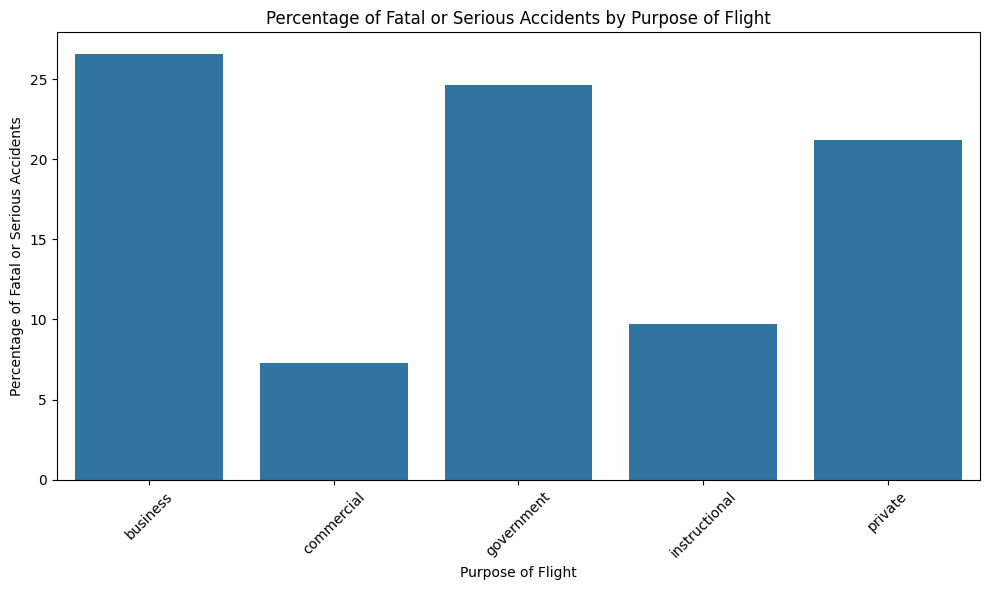

In [222]:
#Filter the specific values in 'purpose_of_flight' that will be graphed
purposes_to_graph = ['private', 'instructional', 'business', 'commercial', 'government']
filtered_data_purp = aviation_data[aviation_data['purpose_of_flight'].isin(purposes_to_graph)]

#Calculate the percentage of serious injury severity, by grouping the data
#Flatten the dataframe, creating a new column 'percentage'
severity_percentage_purp = filtered_data_purp.groupby('purpose_of_flight').apply(lambda x: (x['severity_category'].value_counts(normalize=True)*100)['Fatal or Serious']).reset_index(name='percentage')

#Plot graph
plt.figure(figsize=(10,6))
sns.barplot(x='purpose_of_flight', y='percentage', data=severity_percentage_purp)
plt.title('Percentage of Fatal or Serious Accidents by Purpose of Flight')
plt.xlabel('Purpose of Flight')
plt.ylabel('Percentage of Fatal or Serious Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Interesting. Let's plot the number of severe injuries in comparison to the total number of accidents that occurred per each purpose of flight. To get a better visual.

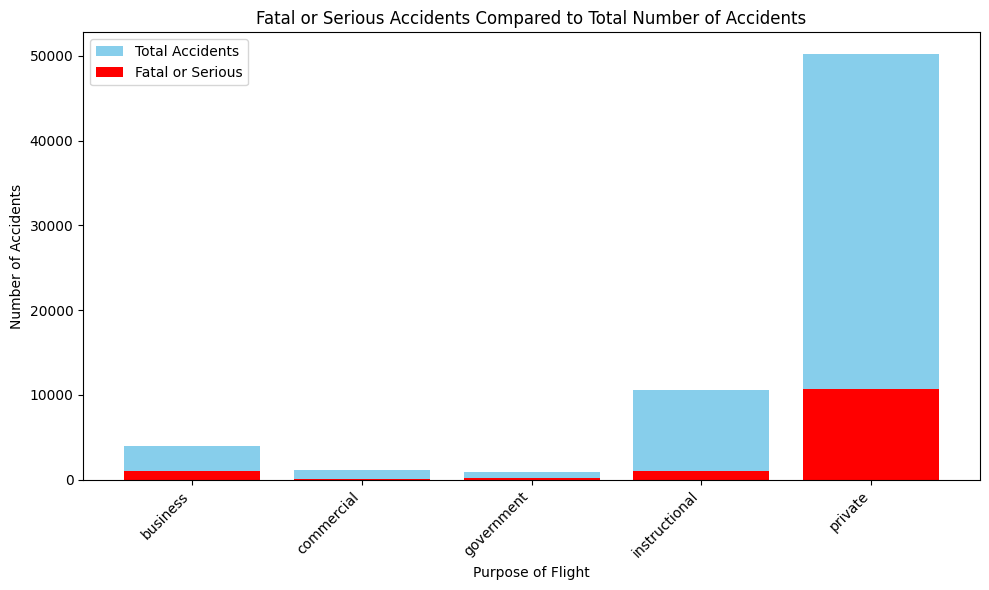

In [223]:
#Total number of accidents per 'purpose_of_flight'
total_accidents_purp = filtered_data_purp.groupby('purpose_of_flight').size().reset_index(name='total_accidents_purp')
#'Fatal or Serious' only from dataframe
fatal_or_serious_purp = filtered_data_purp[filtered_data_purp['severity_category'] == 'Fatal or Serious']

#Grouping by 'purpose_of_flight' to count the number of fatal or serious accidents
fatal_or_serious_counts_purp = fatal_or_serious_purp.groupby('purpose_of_flight').size().reset_index(name='fatal_or_serious_purp')

#Merge the two filtered dataframes on 'purpose_of_flight'
merged_df_purp = pd.merge(total_accidents_purp, fatal_or_serious_counts_purp, on='purpose_of_flight')

#Plot graph
plt.figure(figsize=(10,6))
#Plot the total number of accidents
plt.bar(merged_df_purp['purpose_of_flight'], merged_df_purp['total_accidents_purp'], label='Total Accidents', color='skyblue')
#Plot the 'Fatal or Serious' accidents on top of total accidents
plt.bar(merged_df_purp['purpose_of_flight'], merged_df_purp['fatal_or_serious_purp'], label='Fatal or Serious', color='red')
#Add labels and a title
plt.title('Fatal or Serious Accidents Compared to Total Number of Accidents')
plt.xlabel('Purpose of Flight')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

This drastically changes our perception of these numbers. Let's hone in on **commercial** and flights, since they seem to have a drastically lesser number of accidents. We need to zoom in, in order to get a better sense of the "severity ratio".

Government air travel also appears to be low risk, but this is irrelevant for our analysis. The company to which we are pitching is not affiliated with the government, so they will not have the option to engage in this kind of air travel. "Instructional" air travel is irrelevant to our analysis as well. We can filter those out from now on. 

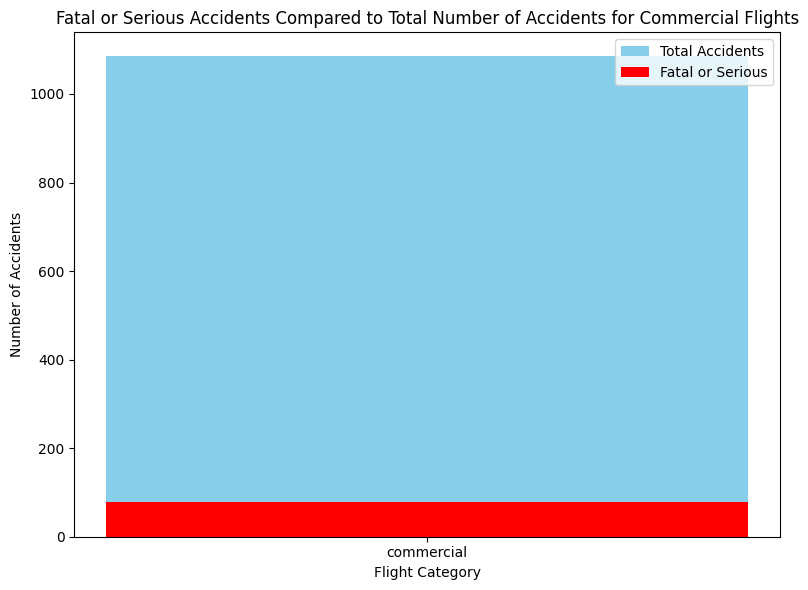

In [224]:
#Plotting the same graph but only for 'commercial' flights
commercial_data_purp = merged_df_purp[merged_df_purp['purpose_of_flight'] == 'commercial']

#Plotting graph
plt.figure(figsize=(8,6))
plt.bar(commercial_data_purp['purpose_of_flight'], commercial_data_purp['total_accidents_purp'], label='Total Accidents', color='skyblue')
plt.bar(commercial_data_purp['purpose_of_flight'], commercial_data_purp['fatal_or_serious_purp'], label='Fatal or Serious', color='red')
plt.title('Fatal or Serious Accidents Compared to Total Number of Accidents for Commercial Flights')
plt.xlabel('Flight Category')
plt.ylabel('Number of Accidents')
plt.legend()
plt.tight_layout()
plt.show()

Clearly, commercial flights are far lower risk: both in terms of total accidents, as well as percentage of accidents that are fatal or serious. 

The highest risk flights seem, by far, to be private. Let's take commercial flights and private flights and examine these further. Accounting for other risk factors such as weather, broad phase of flight, etc. that might be affecting our perception of the numbers. 

## Further Exploration: Commercial vs. Private Flights

### Weather

In [226]:
#Reminding ourselves of unique values in 'weather_condition'
aviation_data['weather_condition'].unique()

array(['unk', 'imc', 'vmc', nan], dtype=object)

Let's look at how many commercial and private flights have 'weather_condition' data available. To make sure we have enough information at our disposal.

In [228]:
#Filter the data for 'commercial' and 'private' flights
commercial_private_flights = aviation_data[aviation_data['purpose_of_flight'].isin(['commercial', 'private'])]

#Count occurrences of 'imc' and 'vmc' weather_condition values, for each category of flight
commercial_imc_count = commercial_private_flights[(commercial_private_flights['purpose_of_flight'] == 'commercial') &
                                                    (commercial_private_flights['weather_condition'] == 'imc')].shape[0]
commercial_vmc_count = commercial_private_flights[(commercial_private_flights['purpose_of_flight'] == 'commercial') &
                                                   (commercial_private_flights['weather_condition'] == 'vmc')].shape[0]
private_imc_count = commercial_private_flights[(commercial_private_flights['purpose_of_flight'] == 'private') &
                                                (commercial_private_flights['weather_condition'] == 'imc')].shape[0]
private_vmc_count = commercial_private_flights[(commercial_private_flights['purpose_of_flight'] == 'private') &
                                                (commercial_private_flights['weather_condition'] == 'vmc')].shape[0]

print("commercial imc count:", commercial_imc_count)
print("commercial vmc count:", commercial_vmc_count)
print("private imc count:", private_imc_count)
print("private_vmc_count:", private_vmc_count)

commercial imc count: 102
commercial vmc count: 475
private imc count: 3374
private_vmc_count: 45889


These numbers are interesting, because for both private and commercial flights, there is a higher number of accidents documented during 'vmc' weather conditions. *IMC* indicates worse weather conditions, with visibility and cloud cover where the pilots must rely on cockpit instruments...IMC is what we consider "worse" weather, so it's interesting that VMC has a higher number of documented accidents.

This could suggest a **problem with pilot navigation**.

Let's plot these numbers with the 'Fatal or Serious' compared to total accidents ratio we were using before.

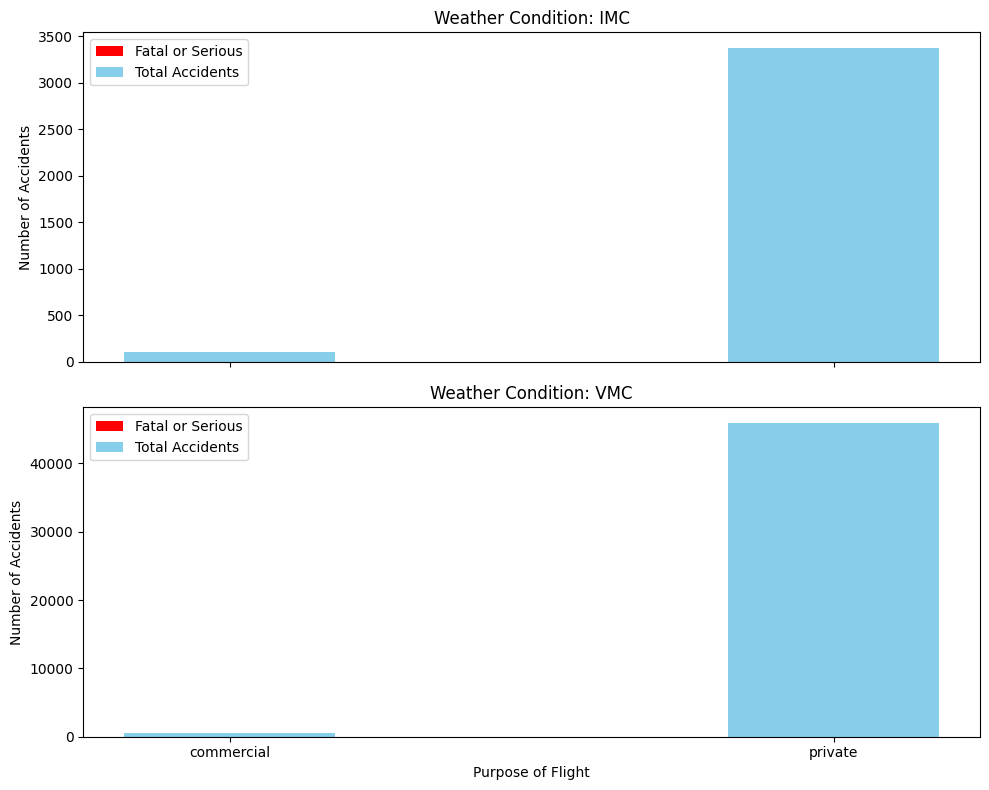

In [235]:
#Get imc and vmc weather conditions
weather_conditions = ['imc', 'vmc']

#Using subplots this tim
fig, axs = plt.subplots(len(weather_conditions), 1, figsize=(10,8), sharex=True)

#Iterating over each weather condition
for i, weather_condition in enumerate(weather_conditions):
    weather_data_purp = commercial_private_flights[commercial_private_flights['weather_condition'] == weather_condition]
    #Group by 'purpose_of_flight'
    grouped_data_purp = weather_data_purp.groupby('purpose_of_flight').agg(
        total_accidents_purp=('accident_number', 'count'),
        fatal_or_serious_purp=('severity_category', lambda x: sum(x == 'Fatal or Serious'))
    ).reset_index()
    
    #Set bar positions
    x = np.arange(len(grouped_data_purp))
    width = 0.35
    #Plot bars for total accidents
    axs[i].bar(x, grouped_data_purp['fatal_or_serious_purp'], width, label='Fatal or Serious', color='red')
    #Plot bars for 'Fatal or Serious' accidents
    axs[i].bar(x, grouped_data_purp['total_accidents_purp'], width, label='Total Accidents', color='skyblue')
    #Labels, title, legend
    axs[i].set_title(f'Weather Condition: {weather_condition.upper()}')
    axs[i].set_ylabel('Number of Accidents')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(grouped_data_purp['purpose_of_flight'])
    axs[i].legend()

#Other labels and layout
plt.xlabel('Purpose of Flight')
plt.tight_layout()
plt.show()

### Broad Phase of Flight

Let's do the same thing examining broad phase of flight, this time looking at only the number of 'fatal or serious' accidents for commercial and privatae flights.

In [236]:
aviation_data['broad_phase_of_flight'].unique()

array(['cruise', 'unknown', 'approach', 'climb', 'takeoff', 'landing',
       'taxi', 'descent', 'maneuvering', 'standing', 'go-around', 'other',
       nan], dtype=object)

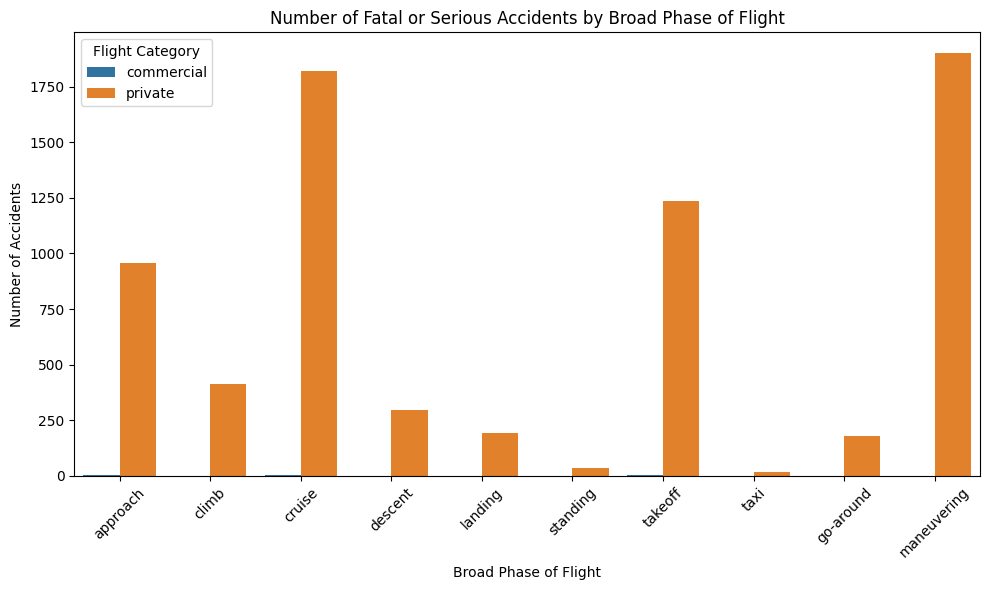

In [238]:
phase_flight = ['cruise', 'approach', 'climb', 'takeoff', 'landing', 'taxi', 'descent', 'maneuvering', 'standing', 'go-around']

filtered_data_pf = commercial_private_flights[commercial_private_flights['broad_phase_of_flight'].isin(phase_flight)]
fatal_or_serious_counts_pf = filtered_data_pf.groupby(['purpose_of_flight', 'broad_phase_of_flight'])['severity_category'].apply(lambda x: (x == 'Fatal or Serious').sum()).reset_index(name='count')

plt.figure(figsize=(10,6))
sns.barplot(x='broad_phase_of_flight', y='count', hue='purpose_of_flight', data=fatal_or_serious_counts_pf)
plt.title('Number of Fatal or Serious Accidents by Broad Phase of Flight')
plt.xlabel('Broad Phase of Flight')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.legend(title='Flight Category')
plt.tight_layout()
plt.show()

Private flights have a drastically higher amount of accidents. Which means it's near impossible to visualize accidents on commercial flights in comparison. Let's do this same graph, but with commercial flights only.

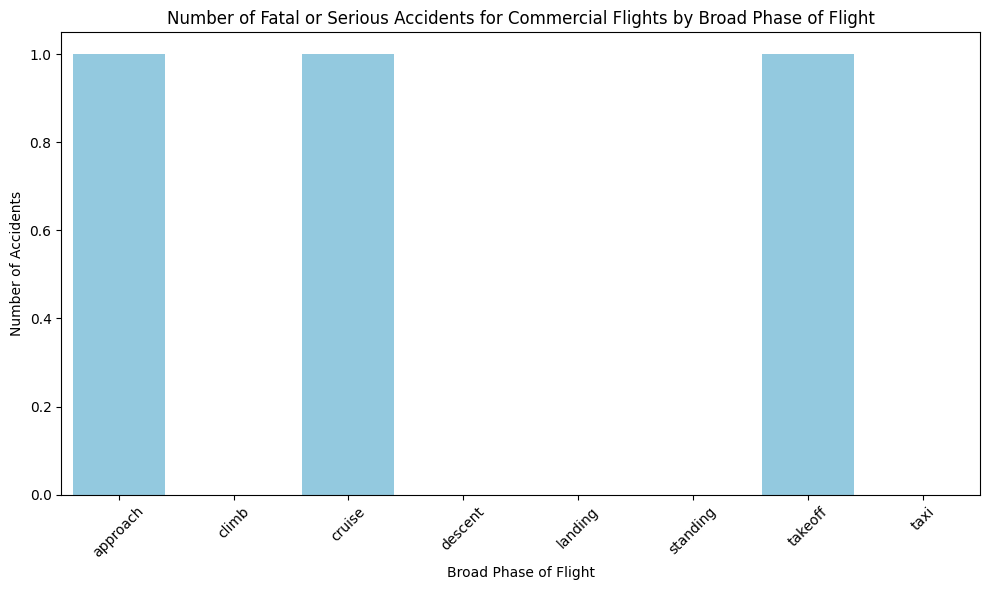

In [239]:
#Filtering data for only commercial flights
commercial_flights = aviation_data[aviation_data['purpose_of_flight'] == 'commercial']
filtered_data_pf = commercial_flights[commercial_flights['broad_phase_of_flight'].isin(phase_flight)]
fatal_or_serious_counts_pf = filtered_data_pf.groupby('broad_phase_of_flight')['severity_category'].apply(lambda x: (x == 'Fatal or Serious').sum()).reset_index(name='count')

plt.figure(figsize=(10,6))
sns.barplot(x='broad_phase_of_flight', y='count', data=fatal_or_serious_counts_pf, color='skyblue')
plt.title('Number of Fatal or Serious Accidents for Commercial Flights by Broad Phase of Flight')
plt.xlabel('Broad Phase of Flight')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [241]:
commercial_flights['broad_phase_of_flight'].value_counts()

broad_phase_of_flight
taxi        19
standing    10
climb        9
landing      9
cruise       6
descent      4
takeoff      3
approach     3
Name: count, dtype: int64

#### Outside research tells us that **landing** is actually the most accident-prone phase of flight. Clearly, there's not enough data to give us accurate depictions of these graphs. We'll keep the graphs in the notebook, in case there's an opportunity to fill in more data. Then our code will update, and these graphs above will have more information.

# Conclusion: Commercial

Commercial flights are by far safer than private flights.

## Features of Aircraft: Number of Engines

Let's examine the features an aircraft needs to be low-risk. Let's graph the number 'fatal or serious' injuries for commercial and private flights based on number of engines.

In [243]:
commercial_private_flights['number_of_engines'].value_counts()

number_of_engines
1    45069
2     4593
4       77
3       43
Name: count, dtype: Int64

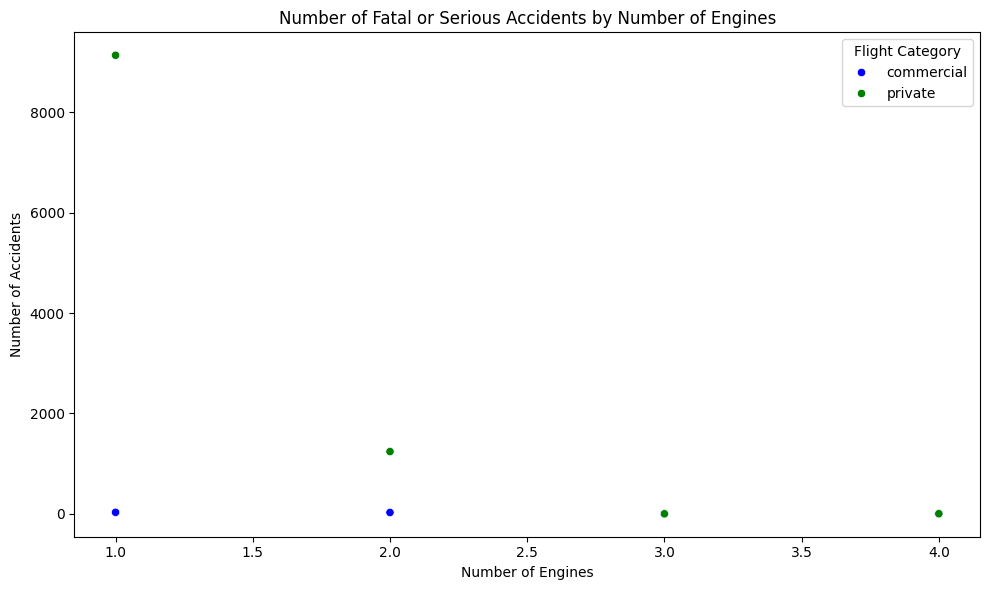

In [244]:
fatal_or_serious_counts = commercial_private_flights.groupby(['purpose_of_flight', 'number_of_engines'])['severity_category'].apply(lambda x: (x == 'Fatal or Serious').sum()).reset_index(name='count')

plt.figure(figsize=(10,6))
sns.scatterplot(x='number_of_engines', y='count', hue='purpose_of_flight', data=fatal_or_serious_counts, palette={'commercial': 'blue', 'private': 'green'})
plt.title('Number of Fatal or Serious Accidents by Number of Engines')
plt.xlabel('Number of Engines')
plt.ylabel('Number of Accidents')
plt.legend(title='Flight Category')
plt.tight_layout()
plt.show()

Woah!!! Not at all enough information. Let's try the same plot, but looking at the total number of accidents.

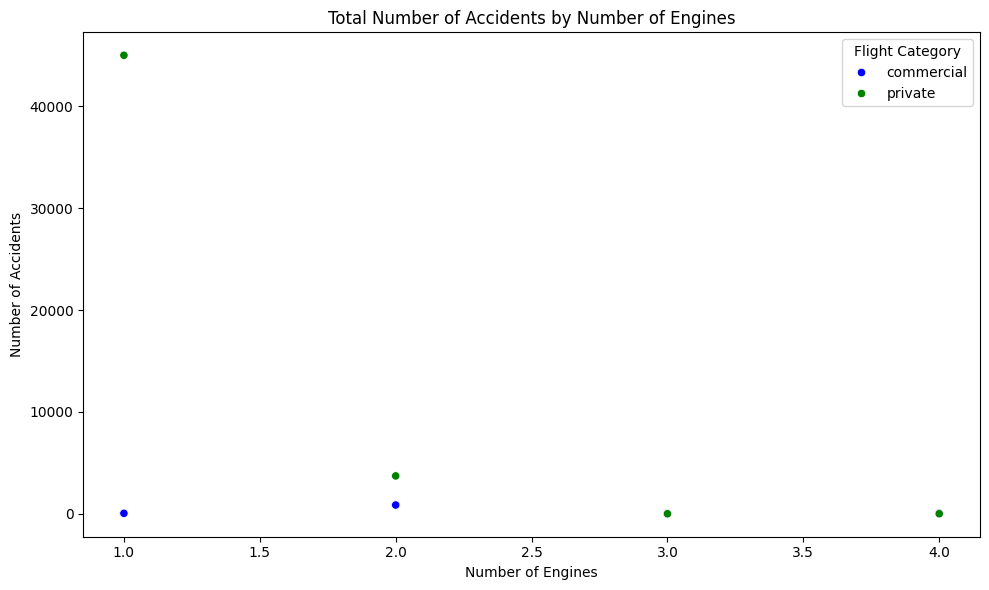

In [246]:
total_accidents_count = commercial_private_flights.groupby(['purpose_of_flight', 'number_of_engines']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='number_of_engines', y='count', hue='purpose_of_flight', data=total_accidents_count, palette={'commercial': 'blue', 'private': 'green'})
plt.title('Total Number of Accidents by Number of Engines')
plt.xlabel('Number of Engines')
plt.ylabel('Number of Accidents')
plt.legend(title='Flight Category')
plt.tight_layout()
plt.show()

Something is off with our data - either it's too concentrated, or not filtered correctly. Let's try the 'Fatal or Serious' plot again, this time with a bar graph.

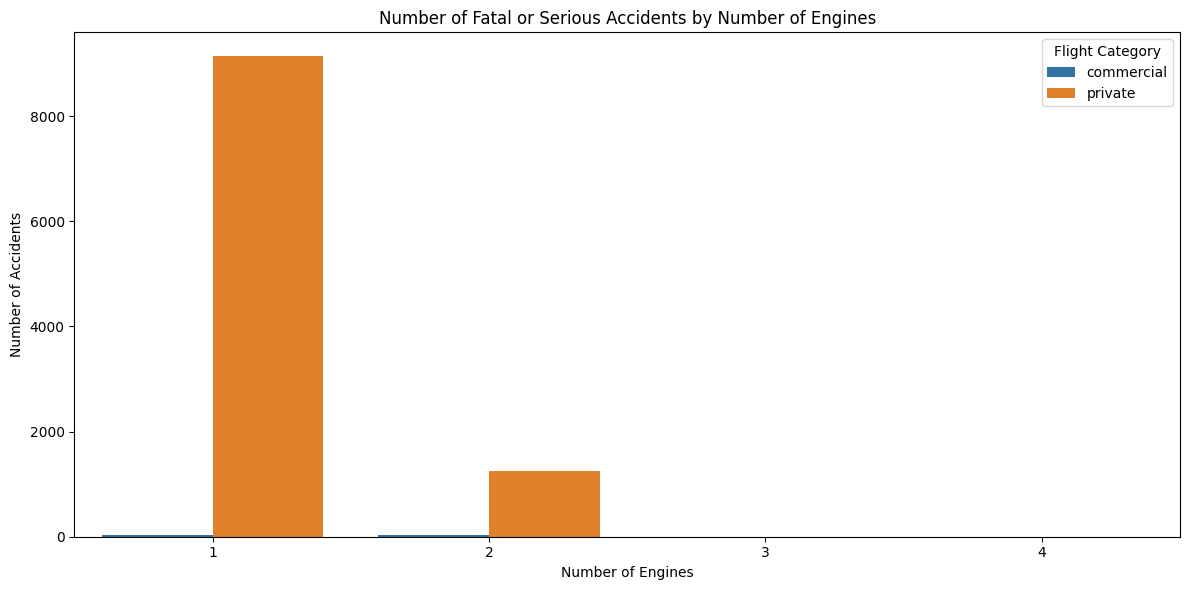

In [248]:
fatal_or_serious_counts = commercial_private_flights.groupby(['number_of_engines', 'purpose_of_flight'])['severity_category'].apply(lambda x: (x == 'Fatal or Serious').sum()).reset_index(name='count')

plt.figure(figsize=(12,6))
sns.barplot(x='number_of_engines', y='count', hue='purpose_of_flight', data=fatal_or_serious_counts)
plt.title('Number of Fatal or Serious Accidents by Number of Engines')
plt.xlabel('Number of Engines')
plt.ylabel('Number of Accidents')
plt.legend(title='Flight Category')
plt.tight_layout()
plt.show()

Clearly, having at least 2 engines is lower-risk. 

Let's adjust our scale and have two separate graphs, so we can look at our commercial flight numbers better.

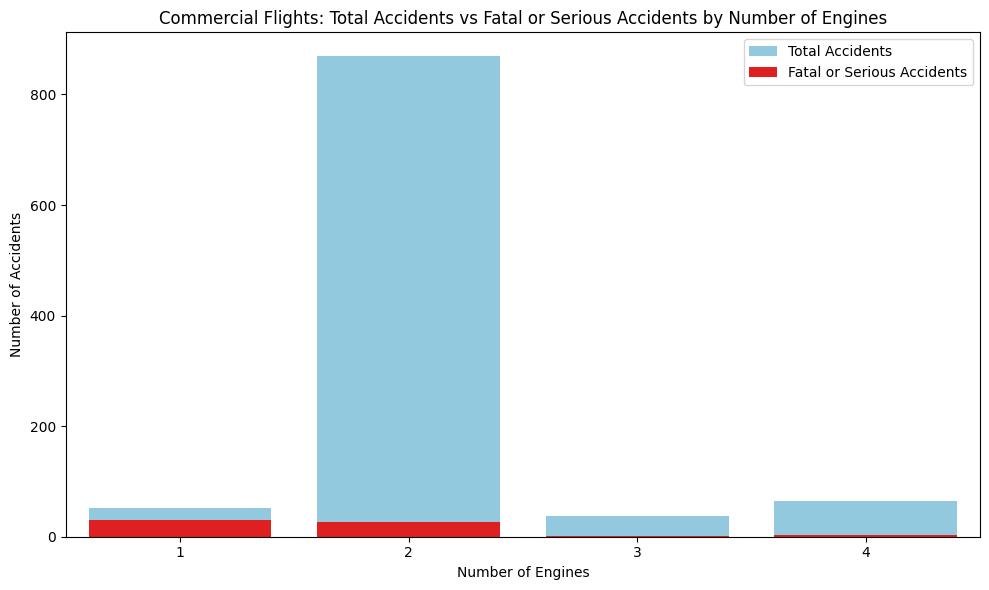

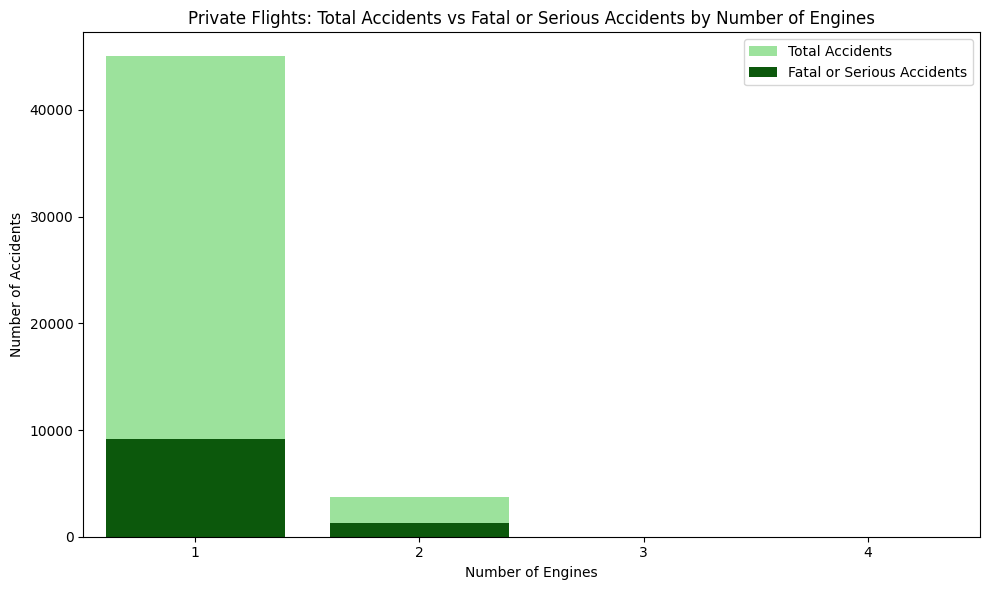

In [251]:
# Filter the data for commercial flights
commercial_flights = aviation_data[aviation_data['purpose_of_flight'] == 'commercial']

# Group the filtered data by 'number_of_engines' and calculate the total number of accidents and 'Fatal or Serious' accidents
total_accidents_commercial = commercial_flights.groupby('number_of_engines').size().reset_index(name='total_accidents')
fatal_or_serious_commercial = commercial_flights[commercial_flights['severity_category'] == 'Fatal or Serious'].groupby('number_of_engines').size().reset_index(name='fatal_or_serious')

# Merge the dataframes to have the 'total_accidents' and 'fatal_or_serious' columns for commercial flights
merged_data_commercial = pd.merge(total_accidents_commercial, fatal_or_serious_commercial, on='number_of_engines', how='outer')

# Plot the bar graph for commercial flights
plt.figure(figsize=(10, 6))
sns.barplot(x='number_of_engines', y='total_accidents', data=merged_data_commercial, color='skyblue', label='Total Accidents')
sns.barplot(x='number_of_engines', y='fatal_or_serious', data=merged_data_commercial, color='red', label='Fatal or Serious Accidents')

plt.title('Commercial Flights: Total Accidents vs Fatal or Serious Accidents by Number of Engines')
plt.xlabel('Number of Engines')
plt.ylabel('Number of Accidents')
plt.legend()
plt.tight_layout()
plt.show()

# Filter the data for private flights
private_flights = aviation_data[aviation_data['purpose_of_flight'] == 'private']

# Group the filtered data by 'number_of_engines' and calculate the total number of accidents and 'Fatal or Serious' accidents
total_accidents_private = private_flights.groupby('number_of_engines').size().reset_index(name='total_accidents')
fatal_or_serious_private = private_flights[private_flights['severity_category'] == 'Fatal or Serious'].groupby('number_of_engines').size().reset_index(name='fatal_or_serious')

# Merge the dataframes to have the 'total_accidents' and 'fatal_or_serious' columns for private flights
merged_data_private = pd.merge(total_accidents_private, fatal_or_serious_private, on='number_of_engines', how='outer')

# Plot the bar graph for private flights
plt.figure(figsize=(10, 6))
sns.barplot(x='number_of_engines', y='total_accidents', data=merged_data_private, color='lightgreen', label='Total Accidents')
sns.barplot(x='number_of_engines', y='fatal_or_serious', data=merged_data_private, color='darkgreen', label='Fatal or Serious Accidents')

plt.title('Private Flights: Total Accidents vs Fatal or Serious Accidents by Number of Engines')
plt.xlabel('Number of Engines')
plt.ylabel('Number of Accidents')
plt.legend()
plt.tight_layout()
plt.show()

Let's check how much data our graph is drawing from.

In [252]:
commercial_flights['number_of_engines'].value_counts()

number_of_engines
2    869
4     65
1     52
3     37
Name: count, dtype: Int64

In [253]:
private_flights['number_of_engines'].value_counts()

number_of_engines
1    45017
2     3724
4       12
3        6
Name: count, dtype: Int64

# Conclusion

If we compare the two graphs above, knowing that **commercial flights are safer** than private flights...then we can conclude that the number of engines found most on commercial airplanes is the lowest-risk.

From this we can deduce that having **2 engines or more** is the low-risk option when purchasing an aircraft.

## Question 3: What are the safest features of an airplane?
'amateur_built', 'number_of_engines', 'engine_type', 'far_description', 'schedule', 'purpose_of_flight'

In [225]:
cols_to_compare = ['amateur_built', 'number_of_engines', 'engine_type', 'far_description', 'schedule', 'purpose_of_flight']

## Question 4: What is the safest airplane?
Here we show what is the safest airplane

## Question 5: What is the safest location for airflight?
Here we show what is the safest location for flying

## Question 6: What is the safest airport for airflight?
Here we show what the safest airport is for airplanes

# 3 Questions 
(missing data with injury counts for all)

1) What is the safest category of flight? (private or commercial) 

2) What are the safest features of an aircraft? (engine type and number) (more missing data) 

3) What is the safest make/manufacturer to buy from?  Bonus what is the safest model (no missing data)